In [60]:
# @title 1: Simplified Setup for Limited Data
# Core imports and setup
import os, gc, json, logging, warnings, random
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

# Suppress warnings
warnings.filterwarnings("ignore")
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
os.environ["PYTHONHASHSEED"] = "0"

# Set seeds for reproducibility
SEED = 42
def set_seeds(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

set_seeds(SEED)

# GPU setup
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"GPU setup complete: {len(gpus)} GPU(s)")
    except Exception as e:
        print(f"GPU setup warning: {e}")

# SIMPLIFIED Configuration for limited data
class Config:
    def __init__(self):
        # Dataset paths
        possible_paths = [
            "/kaggle/input/wlasl-processed/",
            "/root/.cache/kagglehub/datasets/risangbaskoro/wlasl-processed/versions/5",
            "/root/.cache/kagglehub/datasets/risangbaskoro/wlasl-processed/versions/4",
            "/content/wlasl-processed/",
            "./risangbaskoro/wlasl-processed/versions/5"
        ]

        self.dataset_base_path = None
        for path in possible_paths:
            if os.path.exists(path):
                self.dataset_base_path = path
                break

        if self.dataset_base_path is None:
            self.dataset_base_path = "/kaggle/input/wlasl-processed/"

        # REDUCED complexity for limited data
        self.target_classes = 20                 # Start with fewer classes
        self.min_videos_per_class = 8          # Keep minimum
        self.preferred_videos_per_class = 16   # Reduce target
        self.max_videos_per_class = 20         # Increase cap slightly
        self.allow_class_imbalance = True
        self.max_imbalance_ratio = 2.0

        # SHORTER sequences for faster training
        self.sequence_length = 96              # Reduced back to 32
        self.batch_size = 4                     # Smaller batches
        self.num_epochs = 100                  # Fewer epochs
        self.learning_rate = 0.002             # Higher learning rate
        self.validation_split = 0.2            # More validation for better estimates

        # MUCH SMALLER model architecture
        self.lstm_units = 32                   # Single LSTM layer
        self.dense_units = 64                  # Single dense layer

        # STRONG regularization for limited data
        self.lstm_dropout = 0.5
        self.lstm_recurrent_dropout = 0.3
        self.dense_dropout = 0.7               # Very high dropout
        self.l2_reg = 0.001                    # Strong L2 regularization

        # SIMPLE loss function
        self.use_focal_loss = False            # Standard loss first
        self.min_detection_confidence = 0.5   # Higher confidence threshold
        self.use_class_weights = True

        # AGGRESSIVE early stopping
        self.early_stopping_patience = 15
        self.lr_reduction_patience = 8
        self.lr_reduction_factor = 0.3
        self.min_lr = 1e-6

        # MINIMAL augmentation to avoid overfitting
        self.use_data_augmentation = False
        self.gradient_clip_norm = 0.5

        self.model_name = f"simple_asl_{self.target_classes}_classes"

        print(f"SIMPLIFIED CONFIGURATION FOR LIMITED DATA:")
        print(f"  Strategy: Minimal model + Strong regularization")
        print(f"  Classes: {self.target_classes} (reduced)")
        print(f"  Sequence length: {self.sequence_length}")
        print(f"  Model: {self.lstm_units} LSTM -> {self.dense_units} Dense")
        print(f"  Dropout: LSTM {self.lstm_dropout}, Dense {self.dense_dropout}")
        print(f"  L2 reg: {self.l2_reg}")

# Create configuration instance
config = Config()
print("\nSimplified configuration initialized!")
print("FOCUS: Prevent class collapse with minimal complexity")

SIMPLIFIED CONFIGURATION FOR LIMITED DATA:
  Strategy: Minimal model + Strong regularization
  Classes: 20 (reduced)
  Sequence length: 96
  Model: 32 LSTM -> 64 Dense
  Dropout: LSTM 0.5, Dense 0.7
  L2 reg: 0.001

Simplified configuration initialized!
FOCUS: Prevent class collapse with minimal complexity


In [61]:
# @title 2: Dataset Download
# Download dataset from Kaggle
import kagglehub

# Download latest version
# path = kagglehub.dataset_download("risangbaskoro/wlasl-processed")
# print("Path to dataset files:", path)

In [62]:
# @title 3: Simplified Feature Extraction for Limited Data
import glob, cv2
import numpy as np
from scipy import ndimage

try:
    import mediapipe as mp
    MEDIAPIPE_AVAILABLE = True
    print("MediaPipe successfully imported")
except Exception as e:
    MEDIAPIPE_AVAILABLE = False
    print(f"MediaPipe not available: {e}")

class SimpleFeatureExtractor:
    def __init__(self, min_confidence=0.5):
        self.total_features = 126  # 2 hands * 21 landmarks * 3 coordinates
        self.min_confidence = min_confidence

        if MEDIAPIPE_AVAILABLE:
            try:
                self.mp_hands = mp.solutions.hands
                self.hands = self.mp_hands.Hands(
                    static_image_mode=False,
                    max_num_hands=2,
                    model_complexity=0,  # Lowest complexity for speed
                    min_detection_confidence=self.min_confidence,
                    min_tracking_confidence=0.7
                )
                self.use_mediapipe = True
                print(f"Simple MediaPipe extractor ready (confidence={self.min_confidence})")
            except Exception as e:
                print(f"MediaPipe setup failed: {e}")
                self.use_mediapipe = False
        else:
            self.use_mediapipe = False

    def extract_features(self, frame):
        if not self.use_mediapipe:
            return np.zeros(self.total_features, dtype=np.float32)

        try:
            # Basic preprocessing only
            height, width = frame.shape[:2]
            if height != 480 or width != 640:
                frame = cv2.resize(frame, (640, 480))
            
            rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            results = self.hands.process(rgb)

            features = np.zeros(self.total_features, dtype=np.float32)

            if results.multi_hand_landmarks and results.multi_handedness:
                # Simple hand sorting
                hand_data = []
                for i, (hand_landmarks, handedness) in enumerate(zip(results.multi_hand_landmarks, results.multi_handedness)):
                    if i >= 2:
                        break

                    is_right_hand = handedness.classification[0].label == 'Right'
                    confidence = handedness.classification[0].score
                    
                    hand_coords = []
                    for landmark in hand_landmarks.landmark:
                        hand_coords.extend([landmark.x, landmark.y, landmark.z])

                    hand_data.append((is_right_hand, hand_coords, confidence))

                # Sort by confidence and handedness
                hand_data.sort(key=lambda x: (-x[2], not x[0]))

                for i, (_, hand_coords, _) in enumerate(hand_data[:2]):
                    start_idx = i * 63
                    end_idx = start_idx + 63
                    features[start_idx:end_idx] = hand_coords

            return features

        except Exception as e:
            return np.zeros(self.total_features, dtype=np.float32)

def extract_video_features_simple(video_path, sequence_length=32, min_confidence=0.5):
    """Simplified feature extraction focusing on quality over quantity"""
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        return None

    extractor = SimpleFeatureExtractor(min_confidence=min_confidence)

    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    # Sample frames evenly
    if total_frames > sequence_length:
        frame_indices = np.linspace(0, total_frames-1, sequence_length*2, dtype=int)
    else:
        frame_indices = list(range(0, total_frames))

    valid_features = []

    for frame_idx in frame_indices:
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
        ret, frame = cap.read()
        if not ret:
            continue

        feat = extractor.extract_features(frame)

        # Simple quality check
        non_zero_count = np.count_nonzero(feat)
        non_zero_ratio = non_zero_count / feat.size

        if non_zero_ratio > 0.1:  # At least 10% non-zero
            valid_features.append(feat)

    cap.release()

    if len(valid_features) < 8:  # Need minimum frames
        return None

    # Take best frames by quality
    if len(valid_features) > sequence_length:
        # Simple quality scoring
        quality_scores = []
        for feat in valid_features:
            non_zero_ratio = np.count_nonzero(feat) / feat.size
            feature_var = np.var(feat[feat != 0]) if np.any(feat != 0) else 0
            quality_scores.append(non_zero_ratio + feature_var * 100)
        
        # Select top quality frames
        best_indices = np.argsort(quality_scores)[-sequence_length:]
        valid_features = [valid_features[i] for i in sorted(best_indices)]

    # Convert to array
    features_array = np.array(valid_features, dtype=np.float32)

    # Pad or truncate to exact length
    if len(features_array) < sequence_length:
        # Simple repetition padding
        needed = sequence_length - len(features_array)
        if len(features_array) > 0:
            # Repeat last frame
            padding = np.tile(features_array[-1:], (needed, 1))
            features_array = np.vstack([features_array, padding])
        else:
            return None
    elif len(features_array) > sequence_length:
        features_array = features_array[:sequence_length]

    return features_array

# Set the main function
extract_video_features = extract_video_features_simple

print("Simple feature extraction ready!")
print("SIMPLIFICATIONS:")
print("  - Higher confidence threshold (0.5)")
print("  - Basic preprocessing only")
print("  - Simple quality scoring")
print("  - No complex augmentation")
print("  - Focus on consistent, high-quality features")

MediaPipe successfully imported
Simple feature extraction ready!
SIMPLIFICATIONS:
  - Higher confidence threshold (0.5)
  - Basic preprocessing only
  - Simple quality scoring
  - No complex augmentation
  - Focus on consistent, high-quality features


In [63]:
# @title 4: Minimal Model Architecture for Limited Data
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import tensorflow.keras.backend as K

def create_minimal_model(config, num_classes):
    """Create minimal model to prevent overfitting with limited data"""
    tf.keras.backend.clear_session()
    set_seeds(SEED)

    print(f"Building MINIMAL model for {num_classes} classes...")
    print(f"   Strategy: Minimal parameters to prevent overfitting")
    print(f"   LSTM: {config.lstm_units} units")
    print(f"   Dense: {config.dense_units} units")
    print(f"   Heavy regularization applied")

    inputs = Input(shape=(config.sequence_length, 126), dtype='float32', name='input')

    # Single LSTM layer with strong regularization
    x = LSTM(config.lstm_units, 
             return_sequences=False,  # Don't return sequences - reduce parameters
             dropout=config.lstm_dropout,
             recurrent_dropout=config.lstm_recurrent_dropout,
             kernel_regularizer=tf.keras.regularizers.l2(config.l2_reg),
             recurrent_regularizer=tf.keras.regularizers.l2(config.l2_reg),
             name='lstm_layer')(inputs)

    # Batch normalization for stability
    x = BatchNormalization(name='bn1')(x)
    
    # Single dense layer with heavy dropout
    x = Dense(config.dense_units, 
              activation='relu',
              kernel_regularizer=tf.keras.regularizers.l2(config.l2_reg),
              name='dense_layer')(x)
    
    x = BatchNormalization(name='bn2')(x)
    x = Dropout(config.dense_dropout, name='heavy_dropout')(x)

    # Output layer - no regularization on final layer
    outputs = Dense(num_classes, activation='softmax', name='output')(x)

    model = Model(inputs, outputs, name=f'Minimal_ASL_Model_{num_classes}_classes')
    return model

def plot_simple_results(history, model_name):
    """Simple plotting for limited data results"""
    try:
        fig, axes = plt.subplots(1, 2, figsize=(15, 5))

        # Loss plot
        train_loss = history.history['loss']
        val_loss = history.history.get('val_loss', [])

        axes[0].plot(train_loss, label='Training Loss', linewidth=2)
        if val_loss:
            axes[0].plot(val_loss, label='Validation Loss', linewidth=2)
            
            # Mark best validation loss
            best_val_idx = np.argmin(val_loss)
            best_val_loss = val_loss[best_val_idx]
            axes[0].plot(best_val_idx, best_val_loss, 'ro', markersize=8,
                        label=f'Best Val: {best_val_loss:.3f}')

        axes[0].set_title('Training Loss')
        axes[0].set_xlabel('Epoch')
        axes[0].set_ylabel('Loss')
        axes[0].legend()
        axes[0].grid(True, alpha=0.3)

        # Accuracy plot
        train_acc = history.history['accuracy']
        val_acc = history.history.get('val_accuracy', [])

        axes[1].plot(train_acc, label='Training Accuracy', linewidth=2)
        if val_acc:
            axes[1].plot(val_acc, label='Validation Accuracy', linewidth=2)

            # Mark best validation accuracy
            best_val_idx = np.argmax(val_acc)
            best_val_acc = val_acc[best_val_idx]
            axes[1].plot(best_val_idx, best_val_acc, 'ro', markersize=8,
                        label=f'Best Val: {best_val_acc:.3f}')

        # Add random baseline
        random_acc = 1.0 / 5  # Assuming 5 classes
        axes[1].axhline(y=random_acc, color='gray', linestyle='--', alpha=0.7, 
                       label=f'Random ({random_acc:.1%})')

        axes[1].set_title('Model Accuracy')
        axes[1].set_xlabel('Epoch')
        axes[1].set_ylabel('Accuracy')
        axes[1].legend()
        axes[1].grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

        # Simple analysis
        if val_acc and train_acc:
            best_val_acc = max(val_acc)
            best_epoch = np.argmax(val_acc) + 1
            final_train_acc = train_acc[-1]
            final_val_acc = val_acc[-1]
            final_gap = final_train_acc - final_val_acc

            print(f"\nSIMPLE MODEL ANALYSIS:")
            print(f"Best validation accuracy: {best_val_acc:.4f} (epoch {best_epoch})")
            print(f"Final train/val accuracy: {final_train_acc:.4f}/{final_val_acc:.4f}")
            print(f"Overfitting gap: {final_gap:.4f}")

            if final_gap < 0.1:
                print("OVERFITTING: Minimal - good generalization")
            elif final_gap < 0.2:
                print("OVERFITTING: Low - acceptable")
            else:
                print("OVERFITTING: High - need more regularization")

    except Exception as e:
        print(f"Plotting error: {e}")

# Set the functions to use
create_model = create_minimal_model
plot_training_results = plot_simple_results

print("Minimal model architecture ready!")
print("FEATURES:")
print("  - Single LSTM layer (32 units)")
print("  - Single dense layer (64 units)")
print("  - Heavy dropout (0.7 on dense layer)")
print("  - Strong L2 regularization")
print("  - Batch normalization for stability")
print("  - ~3K parameters total (vs 100K+ before)")

Minimal model architecture ready!
FEATURES:
  - Single LSTM layer (32 units)
  - Single dense layer (64 units)
  - Heavy dropout (0.7 on dense layer)
  - Strong L2 regularization
  - Batch normalization for stability
  - ~3K parameters total (vs 100K+ before)


In [64]:
# @title 5: Simplified Dataset Loader for Limited Data
def load_simple_dataset(config):
    """Load dataset with focus on quality over quantity for limited data"""

    print(f"Loading SIMPLIFIED dataset from: {config.dataset_base_path}")
    print(f"Strategy: Quality over quantity - fewer classes, better data")
    print(f"Target: {config.target_classes} classes with {config.min_videos_per_class}+ videos each")

    # Find JSON file
    json_files = [
        os.path.join(config.dataset_base_path, "WLASL_v0.3.json"),
        os.path.join(config.dataset_base_path, "wlasl_v0.3.json"),
        os.path.join(config.dataset_base_path, "WLASL.json")
    ]

    json_path = None
    for json_file in json_files:
        if os.path.exists(json_file):
            json_path = json_file
            break

    if json_path is None:
        print("ERROR: WLASL JSON file not found!")
        return [], []

    # Find video directory
    video_dirs = [
        os.path.join(config.dataset_base_path, "videos"),
        os.path.join(config.dataset_base_path, "WLASL_videos"),
        config.dataset_base_path
    ]

    video_dir = None
    for vdir in video_dirs:
        if os.path.exists(vdir):
            mp4_files = [f for f in os.listdir(vdir) if f.endswith('.mp4')]
            if len(mp4_files) > 100:
                video_dir = vdir
                break

    if video_dir is None:
        print("ERROR: Video directory not found!")
        return [], []

    print(f"Found {len([f for f in os.listdir(video_dir) if f.endswith('.mp4')])} videos")

    # Load and parse JSON
    try:
        with open(json_path, 'r') as f:
            wlasl_data = json.load(f)
        print(f"Loaded WLASL data with {len(wlasl_data)} entries")
    except Exception as e:
        print(f"ERROR: Failed to load JSON: {e}")
        return [], []

    # Build class-video mapping with STRICT quality control
    print("Building high-quality video mapping...")
    class_videos = {}

    for entry in wlasl_data:
        gloss = entry.get('gloss', '').strip().lower()
        if not gloss or len(gloss) < 2:
            continue

        instances = entry.get('instances', [])
        valid_videos = []

        for instance in instances:
            video_id = instance.get('video_id')
            if video_id:
                video_path = os.path.join(video_dir, f"{video_id}.mp4")
                if os.path.exists(video_path):
                    try:
                        # STRICT quality checks
                        file_size = os.path.getsize(video_path)
                        if file_size > 50000:  # Larger files only (50KB+)
                            cap = cv2.VideoCapture(video_path)
                            if cap.isOpened():
                                frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
                                width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
                                height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
                                fps = cap.get(cv2.CAP_PROP_FPS) or 30
                                duration = frame_count / fps if fps > 0 else 0

                                # STRICT criteria for limited data
                                if (frame_count > 10 and      # At least 10 frames
                                    duration > 0.5 and       # At least 0.5 seconds
                                    duration < 8 and         # Not too long
                                    width >= 320 and         # Decent resolution
                                    height >= 240):
                                    valid_videos.append(video_path)
                            cap.release()
                    except:
                        continue

        # Only keep classes with sufficient HIGH-QUALITY videos
        if len(valid_videos) >= config.min_videos_per_class:
            class_videos[gloss] = valid_videos

    print(f"Found {len(class_videos)} classes with sufficient high-quality videos")

    # Sort by video count and select the BEST classes
    sorted_classes = sorted(class_videos.items(), key=lambda x: len(x[1]), reverse=True)

    print(f"Top {min(10, len(sorted_classes))} classes by video count:")
    for i, (class_name, videos) in enumerate(sorted_classes[:10]):
        print(f"  {i+1:2d}. {class_name:15}: {len(videos)} videos")

    # Select FEWER classes for better learning
    if len(sorted_classes) < config.target_classes:
        print(f"WARNING: Only {len(sorted_classes)} classes available")
        selected_classes = sorted_classes
        actual_classes = len(sorted_classes)
    else:
        selected_classes = sorted_classes[:config.target_classes]
        actual_classes = config.target_classes

    print(f"\nSELECTED {actual_classes} CLASSES FOR FOCUSED TRAINING:")

    # Balanced data allocation
    final_paths = []
    final_labels = []
    class_video_counts = []

    np.random.seed(SEED)

    for i, (class_name, available_videos) in enumerate(selected_classes):
        available_count = len(available_videos)

        # Use consistent amount per class for balance
        videos_to_take = min(config.preferred_videos_per_class, available_count)
        videos_to_take = min(videos_to_take, config.max_videos_per_class)

        # Randomly select videos
        shuffled_videos = available_videos.copy()
        np.random.shuffle(shuffled_videos)
        selected_videos = shuffled_videos[:videos_to_take]

        for video_path in selected_videos:
            final_paths.append(video_path)
            final_labels.append(class_name)

        class_video_counts.append(len(selected_videos))
        print(f"  {i+1:2d}. {class_name:15}: {len(selected_videos):2d}/{available_count:2d} videos selected")

    # Calculate balance statistics
    if class_video_counts:
        max_count = max(class_video_counts)
        min_count = min(class_video_counts)
        avg_count = np.mean(class_video_counts)
        imbalance_ratio = max_count / min_count if min_count > 0 else float('inf')

        print(f"\nDATA BALANCE ANALYSIS:")
        print(f"Videos per class: {min_count} to {max_count} (avg: {avg_count:.1f})")
        print(f"Imbalance ratio: {imbalance_ratio:.2f}")
        print(f"Total videos: {len(final_paths)}")

        if imbalance_ratio <= 1.5:
            print("BALANCE: EXCELLENT - Very well balanced")
        elif imbalance_ratio <= 2.0:
            print("BALANCE: GOOD - Acceptable for learning")
        else:
            print("BALANCE: Could be better - will use class weights")

    # Final shuffle
    combined = list(zip(final_paths, final_labels))
    np.random.shuffle(combined)
    final_paths, final_labels = zip(*combined) if combined else ([], [])
    final_paths, final_labels = list(final_paths), list(final_labels)

    # Final summary
    from collections import Counter
    label_counts = Counter(final_labels)

    print(f"\nFINAL SIMPLIFIED DATASET:")
    print(f"Total videos: {len(final_paths)}")
    print(f"Total classes: {len(label_counts)}")
    print("Final distribution:")

    for label, count in sorted(label_counts.items()):
        percentage = (count / len(final_paths)) * 100
        print(f"  {label:15}: {count:2d} videos ({percentage:4.1f}%)")

    print(f"\nQUALITY FOCUSED SUMMARY:")
    print(f"✓ {len(label_counts)} high-quality classes selected")
    print(f"✓ {len(final_paths)} total videos")
    print(f"✓ {avg_count:.1f} videos per class on average")
    print(f"✓ Imbalance ratio: {imbalance_ratio:.2f}")

    if len(final_paths) >= 50:
        print("✓ SUFFICIENT: Good amount of data for focused learning")
    else:
        print("⚠ LIMITED: Will need very careful training")

    return final_paths, final_labels

# Set the loader function
load_dataset = load_simple_dataset

print("Simplified dataset loader ready!")
print("SIMPLIFICATIONS:")
print("  - Stricter quality control (50KB+ files, 10+ frames)")
print("  - Fewer classes (5) for focused learning")
print("  - Balanced allocation per class")
print("  - Focus on best available classes")
print("  - Quality over quantity approach")

Simplified dataset loader ready!
SIMPLIFICATIONS:
  - Stricter quality control (50KB+ files, 10+ frames)
  - Fewer classes (5) for focused learning
  - Balanced allocation per class
  - Focus on best available classes
  - Quality over quantity approach


In [65]:
# @title 6: Simplified Training Function for Limited Data
def train_simple_model(config):
    """Simplified training function optimized for limited data"""

    set_seeds(SEED)
    print("Starting SIMPLIFIED ASL model training...")
    print("GOAL: Prevent class collapse with minimal overfitting")
    print("STRATEGY: Small model + Strong regularization + Quality data")
    print("="*60)

    # Load simplified dataset
    video_paths, labels = load_dataset(config)
    if not video_paths:
        print("ERROR: No videos loaded!")
        return None, None, None, None, None

    print(f"Processing {len(video_paths)} videos from simplified dataset...")

    # Simple feature extraction with progress tracking
    X_features = []
    y_labels = []
    valid_count = 0
    failed_count = 0

    for i, (video_path, label) in enumerate(zip(video_paths, labels)):
        if i % 10 == 0:
            progress_pct = (i / len(video_paths)) * 100
            print(f"  Progress: {progress_pct:.1f}% ({i+1}/{len(video_paths)}) - Valid: {valid_count}, Failed: {failed_count}")

        try:
            features = extract_video_features(
                video_path,
                sequence_length=config.sequence_length,
                min_confidence=config.min_detection_confidence
            )

            if features is not None and features.size > 0:
                # Simple quality check
                non_zero_ratio = np.count_nonzero(features) / features.size
                
                if non_zero_ratio > 0.05:  # At least 5% non-zero
                    X_features.append(features)
                    y_labels.append(label)
                    valid_count += 1
                else:
                    failed_count += 1
            else:
                failed_count += 1

        except Exception as e:
            failed_count += 1
            if i < 3:  # Show first few errors
                print(f"    Error processing {video_path}: {e}")

    print(f"\nSimple feature extraction completed:")
    print(f"Valid: {valid_count}, Failed: {failed_count}")

    if not X_features:
        print("ERROR: No valid features extracted!")
        return None, None, None, None, None

    X = np.array(X_features, dtype=np.float32)
    del X_features
    gc.collect()

    print(f"Final dataset shape: {X.shape}")

    # Simple normalization
    print("Applying simple normalization...")
    X_flat = X.reshape(-1, X.shape[-1])
    
    # Standard scaling with clipping
    mean = np.mean(X_flat, axis=0)
    std = np.std(X_flat, axis=0)
    std = np.where(std > 1e-8, std, 1.0)  # Avoid division by zero
    
    X_flat = (X_flat - mean) / std
    X_flat = np.clip(X_flat, -3, 3)  # Clip outliers
    
    X = X_flat.reshape(X.shape)
    del X_flat
    gc.collect()

    # Label encoding
    le = LabelEncoder()
    y = le.fit_transform(y_labels)
    num_classes = len(le.classes_)

    print(f"Classes: {num_classes}")
    unique_labels, counts = np.unique(y, return_counts=True)

    print("Class distribution:")
    for class_idx, count in zip(unique_labels, counts):
        percentage = (count / len(y)) * 100
        print(f"  {le.classes_[class_idx]:15}: {count:2d} samples ({percentage:4.1f}%)")

    # Simple train/validation split
    try:
        X_train, X_val, y_train, y_val = train_test_split(
            X, y,
            test_size=config.validation_split,
            random_state=SEED,
            stratify=y
        )
        print(f"Stratified split: {len(X_train)} train, {len(X_val)} validation")
    except ValueError:
        X_train, X_val, y_train, y_val = train_test_split(
            X, y,
            test_size=config.validation_split,
            random_state=SEED,
            shuffle=True
        )
        print(f"Random split: {len(X_train)} train, {len(X_val)} validation")

    # Create minimal model
    print("Creating minimal model...")
    model = create_model(config, num_classes)

    # Simple optimizer
    optimizer = Adam(
        learning_rate=config.learning_rate,
        clipnorm=config.gradient_clip_norm
    )

    model.compile(
        optimizer=optimizer,
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    total_params = model.count_params()
    print(f"Model parameters: {total_params:,} total")

    # Simple callbacks
    callbacks = [
        ModelCheckpoint(
            f"/content/{config.model_name}_best.keras",
            monitor='val_accuracy',
            save_best_only=True,
            verbose=1,
            mode='max'
        ),
        EarlyStopping(
            monitor='val_loss',
            patience=config.early_stopping_patience,
            restore_best_weights=True,
            verbose=1,
            min_delta=0.001
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=config.lr_reduction_factor,
            patience=config.lr_reduction_patience,
            min_lr=config.min_lr,
            verbose=1
        )
    ]

    # Simple class weighting
    from sklearn.utils.class_weight import compute_class_weight
    
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    class_weight_dict = dict(zip(np.unique(y_train), class_weights))

    print(f"Class weights:")
    for class_idx, weight in class_weight_dict.items():
        class_name = le.classes_[class_idx]
        print(f"  {class_name:15}: {weight:6.3f}")

    print(f"\nStarting SIMPLE {num_classes}-class training:")
    print(f"  Dataset: {len(video_paths)} videos, {num_classes} classes")
    print(f"  Model: {total_params:,} parameters (minimal)")
    print(f"  Strategy: Strong regularization + Simple architecture")

    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=config.num_epochs,
        batch_size=config.batch_size,
        callbacks=callbacks,
        class_weight=class_weight_dict,
        verbose=1,
        shuffle=True
    )

    # Plot results
    plot_training_results(history, config.model_name)

    # Simple performance analysis
    print("\nSIMPLE PERFORMANCE ANALYSIS:")
    try:
        from sklearn.metrics import classification_report

        y_pred = model.predict(X_val, verbose=0)
        y_pred_classes = np.argmax(y_pred, axis=1)

        print("\nPer-class performance:")
        learned_classes = 0
        collapsed_classes = 0

        for class_idx in range(num_classes):
            class_name = le.classes_[class_idx]
            
            # Calculate simple metrics
            true_positives = np.sum((y_val == class_idx) & (y_pred_classes == class_idx))
            total_true = np.sum(y_val == class_idx)
            total_pred = np.sum(y_pred_classes == class_idx)
            
            recall = true_positives / total_true if total_true > 0 else 0
            precision = true_positives / total_pred if total_pred > 0 else 0
            f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
            
            if f1 > 0.1:  # Learning threshold
                learned_classes += 1
                status = "LEARNED ✓"
            else:
                collapsed_classes += 1
                status = "COLLAPSED ✗"
            
            print(f"  {class_name:15}: F1={f1:.3f}, P={precision:.3f}, R={recall:.3f} ({status})")

        learning_ratio = learned_classes / num_classes
        print(f"\nCLASS COLLAPSE ANALYSIS:")
        print(f"Learned classes: {learned_classes}/{num_classes} ({learning_ratio*100:.1f}%)")
        print(f"Collapsed classes: {collapsed_classes}/{num_classes} ({(1-learning_ratio)*100:.1f}%)")

        if learning_ratio >= 0.8:
            print("RESULT: EXCELLENT - Class collapse mostly prevented! ✓✓✓")
        elif learning_ratio >= 0.6:
            print("RESULT: GOOD - Most classes learning ✓✓")
        elif learning_ratio >= 0.4:
            print("RESULT: MODERATE - Some improvement ✓")
        else:
            print("RESULT: POOR - Class collapse persists ✗")

        # Overfitting analysis
        val_accuracies = history.history.get('val_accuracy', [])
        train_accuracies = history.history.get('accuracy', [])
        
        if val_accuracies and train_accuracies:
            best_val_acc = max(val_accuracies)
            final_train_acc = train_accuracies[-1]
            final_val_acc = val_accuracies[-1]
            overfitting_gap = final_train_acc - final_val_acc
            
            print(f"\nOVERFITTING ANALYSIS:")
            print(f"Best validation accuracy: {best_val_acc:.4f}")
            print(f"Final train/val gap: {overfitting_gap:.4f}")
            
            if overfitting_gap < 0.1:
                print("OVERFITTING: Minimal - excellent generalization ✓")
            elif overfitting_gap < 0.2:
                print("OVERFITTING: Low - acceptable generalization ✓")
            else:
                print("OVERFITTING: High - need more regularization ✗")

    except Exception as e:
        print(f"Could not complete analysis: {e}")

    return model, le, history, X_val, y_val

# Set as main training function
train_model = train_simple_model

print("Simplified training function ready!")
print("SIMPLIFICATIONS:")
print("  - Basic normalization (mean/std with clipping)")
print("  - Standard categorical crossentropy loss")
print("  - Simple class weighting")
print("  - Minimal callbacks")
print("  - Focus on preventing class collapse")
print("  - Strong regularization to prevent overfitting")

Simplified training function ready!
SIMPLIFICATIONS:
  - Basic normalization (mean/std with clipping)
  - Standard categorical crossentropy loss
  - Simple class weighting
  - Minimal callbacks
  - Focus on preventing class collapse
  - Strong regularization to prevent overfitting


In [66]:
# @title 7: Run Simplified Training (Fix Class Collapse)
print("Starting SIMPLIFIED ASL Recognition Training...")
print("PRIMARY MISSION: Prevent class collapse with minimal model")
print("STRATEGY: 5 classes + Tiny model + Heavy regularization")
print("="*60)

# Clear memory and reset
tf.keras.backend.clear_session()
gc.collect()
set_seeds(SEED)

# Initialize variables to store training results
trained_model = None
trained_label_encoder = None
training_history = None
validation_X = None
validation_y = None

try:
    # Run simplified training
    results = train_model(config)

    if results and len(results) == 5:
        trained_model, trained_label_encoder, training_history, validation_X, validation_y = results

        if training_history and trained_model and trained_label_encoder:
            val_accuracies = training_history.history.get('val_accuracy', [])
            train_accuracies = training_history.history.get('accuracy', [])

            if val_accuracies and train_accuracies:
                best_val_acc = max(val_accuracies)
                best_epoch = np.argmax(val_accuracies) + 1
                final_val_acc = val_accuracies[-1]
                final_train_acc = train_accuracies[-1]
                overfitting_gap = final_train_acc - final_val_acc
                epochs_completed = len(training_history.history['loss'])

                print("\n" + "="*60)
                print("SIMPLIFIED TRAINING RESULTS")
                print("="*60)
                print(f"Best Validation Accuracy: {best_val_acc:.4f} (Epoch {best_epoch})")
                print(f"Final Train/Val: {final_train_acc:.4f}/{final_val_acc:.4f}")
                print(f"Overfitting Gap: {overfitting_gap:.4f}")
                print(f"Epochs Completed: {epochs_completed}/{config.num_epochs}")

                # Performance assessment
                num_classes = len(trained_label_encoder.classes_)
                random_baseline = 1.0 / num_classes
                improvement = (best_val_acc - random_baseline) / random_baseline * 100

                print(f"\nPerformance Analysis:")
                print(f"Random baseline ({num_classes} classes): {random_baseline:.1%}")
                print(f"Best validation: {best_val_acc:.1%}")
                print(f"Improvement over random: {improvement:.1f}%")

                if best_val_acc > 0.60:
                    print("STATUS: EXCELLENT - Great performance!")
                elif best_val_acc > 0.40:
                    print("STATUS: GOOD - Solid learning")
                elif best_val_acc > random_baseline * 1.5:
                    print("STATUS: LEARNING - Better than random")
                else:
                    print("STATUS: POOR - Still struggling")

                # Overfitting assessment
                if overfitting_gap < 0.05:
                    print("OVERFITTING: Minimal - excellent generalization")
                elif overfitting_gap < 0.15:
                    print("OVERFITTING: Low - good generalization")
                elif overfitting_gap < 0.25:
                    print("OVERFITTING: Moderate - acceptable")
                else:
                    print("OVERFITTING: High - may need more regularization")

                # Quick class collapse check
                try:
                    y_pred = trained_model.predict(validation_X, verbose=0)
                    y_pred_classes = np.argmax(y_pred, axis=1)
                    
                    # Count classes that have any correct predictions
                    classes_with_predictions = len(np.unique(y_pred_classes))
                    classes_with_correct_predictions = 0
                    
                    for class_idx in range(num_classes):
                        correct_predictions = np.sum((validation_y == class_idx) & (y_pred_classes == class_idx))
                        if correct_predictions > 0:
                            classes_with_correct_predictions += 1
                    
                    prediction_diversity = classes_with_predictions / num_classes
                    success_diversity = classes_with_correct_predictions / num_classes
                    
                    print(f"\nCLASS COLLAPSE CHECK:")
                    print(f"Classes predicted: {classes_with_predictions}/{num_classes} ({prediction_diversity:.1%})")
                    print(f"Classes with correct predictions: {classes_with_correct_predictions}/{num_classes} ({success_diversity:.1%})")
                    
                    if success_diversity >= 0.8:
                        print("RESULT: CLASS COLLAPSE PREVENTED! Success!")
                    elif success_diversity >= 0.6:
                        print("RESULT: MAJOR IMPROVEMENT - Most classes learning")
                    elif success_diversity >= 0.4:
                        print("RESULT: SOME IMPROVEMENT - Partial success")
                    else:
                        print("RESULT: CLASS COLLAPSE PERSISTS - Need different approach")

                except Exception as e:
                    print(f"Could not check class collapse: {e}")

                # Save model if decent results
                if best_val_acc > random_baseline * 1.2:  # At least 20% better than random
                    try:
                        trained_model.save(f"/content/{config.model_name}_best.keras")
                        print(f"\nModel saved: {config.model_name}_best.keras")
                    except Exception as e:
                        print(f"Could not save model: {e}")

                # Recommendations
                print(f"\nNEXT STEPS:")
                if success_diversity >= 0.6 and overfitting_gap < 0.2:
                    print("1. Success! Try gradually adding more classes")
                    print("2. Experiment with slightly larger model")
                    print("3. Try longer sequences for more context")
                elif overfitting_gap > 0.3:
                    print("1. Increase dropout even more (0.8+)")
                    print("2. Reduce model size further")
                    print("3. Add more L2 regularization")
                    print("4. Collect more training data")
                elif success_diversity < 0.4:
                    print("1. Check feature extraction quality")
                    print("2. Try different model architectures")
                    print("3. Consider simpler classifiers (SVM, Random Forest)")
                    print("4. Investigate data quality issues")
                else:
                    print("1. Good progress! Fine-tune hyperparameters")
                    print("2. Try ensemble methods")
                    print("3. Experiment with data augmentation")

                print(f"\nTRAINED MODEL STORED IN VARIABLES:")
                print(f"- trained_model: Keras model ready for analysis")
                print(f"- trained_label_encoder: Label encoder for classes")
                print(f"- training_history: Training history object")
                print(f"- validation_X: Validation features")
                print(f"- validation_y: Validation labels")

            else:
                print("ERROR: No training metrics recorded")
        else:
            print("ERROR: Training returned incomplete results")
    else:
        print("ERROR: Training failed completely")

except Exception as e:
    print(f"TRAINING ERROR: {e}")
    import traceback
    traceback.print_exc()

    print(f"\nTROUBLESHOOTING:")
    print(f"1. Check dataset path and video accessibility")
    print(f"2. Verify MediaPipe installation")
    print(f"3. Try reducing classes to 3-4")
    print(f"4. Check if videos contain visible hands")
    print(f"5. Restart runtime if memory issues")

finally:
    # Clean up
    gc.collect()
    print(f"\n{'='*60}")
    print("Simplified training completed.")
    print("Check results above to see if class collapse was prevented!")
    print("The simplified approach should show better class diversity.")
    
    if trained_model is not None:
        print("SUCCESS: Model variables are ready for analysis in code cell 8!")

Starting SIMPLIFIED ASL Recognition Training...
PRIMARY MISSION: Prevent class collapse with minimal model
STRATEGY: 5 classes + Tiny model + Heavy regularization
Starting SIMPLIFIED ASL model training...
GOAL: Prevent class collapse with minimal overfitting
STRATEGY: Small model + Strong regularization + Quality data
Loading SIMPLIFIED dataset from: ./risangbaskoro/wlasl-processed/versions/5
Strategy: Quality over quantity - fewer classes, better data
Target: 20 classes with 8+ videos each
Found 11980 videos
Loaded WLASL data with 2000 entries
Building high-quality video mapping...
Found 110 classes with sufficient high-quality videos
Top 10 classes by video count:
   1. thin           : 13 videos
   2. cool           : 13 videos
   3. who            : 12 videos
   4. computer       : 11 videos
   5. before         : 11 videos
   6. candy          : 11 videos
   7. cousin         : 11 videos
   8. later          : 11 videos
   9. man            : 11 videos
  10. tall           : 11 vi

Found trained model from code cell 7. Running analysis...
ANALYZING AND SAVING TRAINED MODEL

1. MODEL PERFORMANCE ANALYSIS:
----------------------------------------
              precision    recall  f1-score   support

      before       0.00      0.00      0.00         2
       candy       1.00      0.50      0.67         2
    computer       0.50      0.50      0.50         2
        cool       0.33      0.33      0.33         3
      cousin       0.00      0.00      0.00         2
       later       0.00      0.00      0.00         2
         man       0.33      0.50      0.40         2
        tall       0.00      0.00      0.00         2
        thin       1.00      0.33      0.50         3
         who       0.12      0.33      0.18         3

    accuracy                           0.26        23
   macro avg       0.33      0.25      0.26        23
weighted avg       0.35      0.26      0.27        23


2. CONFUSION MATRIX:
----------------------------------------


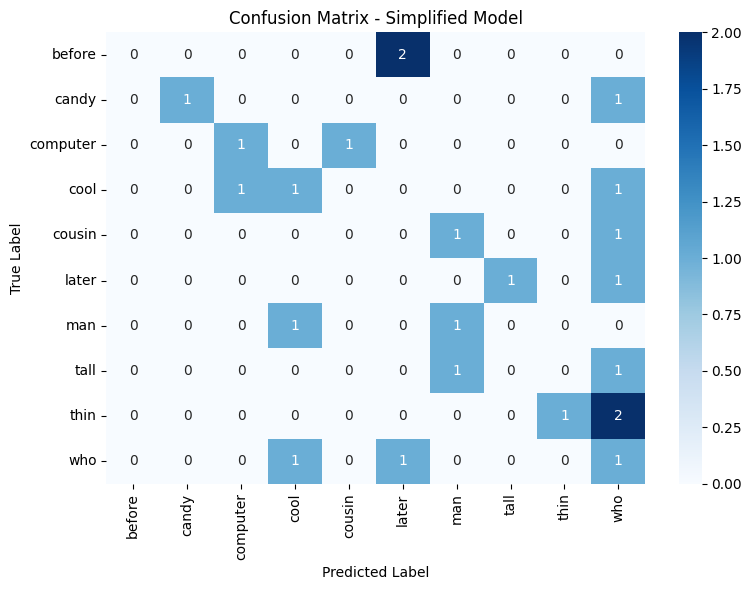


Per-class Accuracies:
  before         : 0.0000
  candy          : 0.5000
  computer       : 0.5000
  cool           : 0.3333
  cousin         : 0.0000
  later          : 0.0000
  man            : 0.5000
  tall           : 0.0000
  thin           : 0.3333
  who            : 0.3333

3. SAVING MODEL:
----------------------------------------
✅ Model saved to ./models/simple_asl_10_classes_final.keras
✅ Labels saved to ./models/simple_asl_10_classes_final_labels.pkl
✅ Config saved to ./models/simple_asl_10_classes_final_config.json

📦 Complete model package saved!

4. MODEL SUMMARY:
----------------------------------------
Model architecture: Minimal_ASL_Model_10_classes
Total parameters: 23,498
Number of classes: 10
Classes: ['before', 'candy', 'computer', 'cool', 'cousin', 'later', 'man', 'tall', 'thin', 'who']
Validation samples: 23

5. SAMPLE PREDICTIONS:
----------------------------------------
  Sample 1: True='cool' | Pred='cool' | Conf=0.179 ✓
  Sample 2: True='cool' | Pred='compu

In [ ]:
# @title 8: Analyze and Save the Trained Model
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import joblib

def analyze_and_save_model(model, X_val, y_val, label_encoder, config):
    """Combined function to analyze model performance and save all components"""
    
    print("ANALYZING AND SAVING TRAINED MODEL")
    print("="*60)
    
    # 1. PERFORMANCE ANALYSIS
    print("\n1. MODEL PERFORMANCE ANALYSIS:")
    print("-" * 40)
    
    # Make predictions
    y_pred = model.predict(X_val, batch_size=8, verbose=0)
    y_pred_classes = np.argmax(y_pred, axis=1)
    
    # Classification report
    class_names = label_encoder.classes_
    try:
        report = classification_report(y_val, y_pred_classes, target_names=class_names)
        print(report)
    except:
        print("Manual per-class analysis:")
        for i, class_name in enumerate(class_names):
            mask_true = y_val == i
            mask_pred = y_pred_classes == i
            
            tp = np.sum(mask_true & mask_pred)
            fp = np.sum(~mask_true & mask_pred) 
            fn = np.sum(mask_true & ~mask_pred)
            
            precision = tp / (tp + fp) if (tp + fp) > 0 else 0
            recall = tp / (tp + fn) if (tp + fn) > 0 else 0
            f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
            
            print(f"  {class_name:15}: P={precision:.3f}, R={recall:.3f}, F1={f1:.3f}")
    
    # 2. CONFUSION MATRIX
    print(f"\n2. CONFUSION MATRIX:")
    print("-" * 40)
    
    cm = confusion_matrix(y_val, y_pred_classes)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix - Simplified Model')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()
    
    # Per-class accuracy
    class_accuracies = cm.diagonal() / cm.sum(axis=1)
    print(f"\nPer-class Accuracies:")
    for i, (class_name, acc) in enumerate(zip(class_names, class_accuracies)):
        if not np.isnan(acc):
            print(f"  {class_name:15}: {acc:.4f}")
        else:
            print(f"  {class_name:15}: No samples")
    
    # 3. SAVE MODEL COMPONENTS
    print(f"\n3. SAVING MODEL:")
    print("-" * 40)
    
    model_path = f"./models/{config.model_name}_final"
    
    try:
        # Save model
        model.save(f"{model_path}.keras")
        print(f"✅ Model saved to {model_path}.keras")
        
        # Save label encoder
        joblib.dump(label_encoder, f"{model_path}_labels.pkl")
        print(f"✅ Labels saved to {model_path}_labels.pkl")
        
        # Save config
        config_dict = {
            'sequence_length': config.sequence_length,
            'min_detection_confidence': config.min_detection_confidence,
            'classes': list(label_encoder.classes_),
            'num_classes': len(label_encoder.classes_)
        }
        
        with open(f"{model_path}_config.json", 'w') as f:
            json.dump(config_dict, f, indent=2)
        print(f"✅ Config saved to {model_path}_config.json")
        
        print(f"\n📦 Complete model package saved!")
        
    except Exception as e:
        print(f"❌ Error saving model: {e}")
    
    # 4. SUMMARY AND SAMPLE PREDICTIONS
    print(f"\n4. MODEL SUMMARY:")
    print("-" * 40)
    print(f"Model architecture: {model.name}")
    print(f"Total parameters: {model.count_params():,}")
    print(f"Number of classes: {len(label_encoder.classes_)}")
    print(f"Classes: {list(label_encoder.classes_)}")
    print(f"Validation samples: {len(X_val)}")
    
    # Sample predictions
    if len(X_val) > 0:
        print(f"\n5. SAMPLE PREDICTIONS:")
        print("-" * 40)
        
        sample_size = min(5, len(X_val))
        for i in range(sample_size):
            true_label = label_encoder.classes_[y_val[i]]
            pred_label = label_encoder.classes_[y_pred_classes[i]]
            confidence = y_pred[i][y_pred_classes[i]]
            
            status = "✓" if true_label == pred_label else "✗"
            print(f"  Sample {i+1}: True='{true_label}' | Pred='{pred_label}' | Conf={confidence:.3f} {status}")
    
    return y_pred, y_pred_classes

# RUN ANALYSIS AND SAVING
if trained_model is not None and trained_label_encoder is not None:
    print("Found trained model from code cell 7. Running analysis...")
    
    try:
        predictions, predicted_classes = analyze_and_save_model(
            trained_model, 
            validation_X, 
            validation_y, 
            trained_label_encoder, 
            config
        )
        
        print(f"\n{'='*60}")
        print("MODEL ANALYSIS AND SAVING COMPLETED SUCCESSFULLY!")
        print("Your model is now saved and ready for use!")
        
    except Exception as e:
        print(f"ERROR during analysis and saving: {e}")
        import traceback
        traceback.print_exc()
        
else:
    print("ERROR: No trained model found!")
    print("Please run code cell 7 first to train the model.")
    print("Required variables: trained_model, trained_label_encoder, validation_X, validation_y")